# Загрузка библиотек

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import random

from sklearn.model_selection import train_test_split
from timm.models import create_model
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from torchvision import transforms

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Загрузка данных с kaggle

In [ ]:
path = kagglehub.dataset_download('jehanbhathena/weather-dataset')

In [ ]:
data = list()

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        label = dirname.split('\\')[-1]
        image = os.path.join(dirname, filename)
        data.append((label, image))

In [ ]:
df = pd.DataFrame(data, columns=['label', 'image'])
df.head()

,label,image
0,dew,C:\Users\Ivan\.cache\kagglehub\datasets\jehanb...
1,dew,C:\Users\Ivan\.cache\kagglehub\datasets\jehanb...
2,dew,C:\Users\Ivan\.cache\kagglehub\datasets\jehanb...
3,dew,C:\Users\Ivan\.cache\kagglehub\datasets\jehanb...
4,dew,C:\Users\Ivan\.cache\kagglehub\datasets\jehanb...


In [ ]:
class_names = {
    0: 'dew',
    1: 'fog/smog',
    2: 'frost',
    3: 'glaze',
    4: 'hail',
    5: 'lightning',
    6: 'rain',
    7: 'rainbow',
    8: 'rime',
    9: 'sandstorm',
    10: 'snow'
}

# Информация о полученных данных

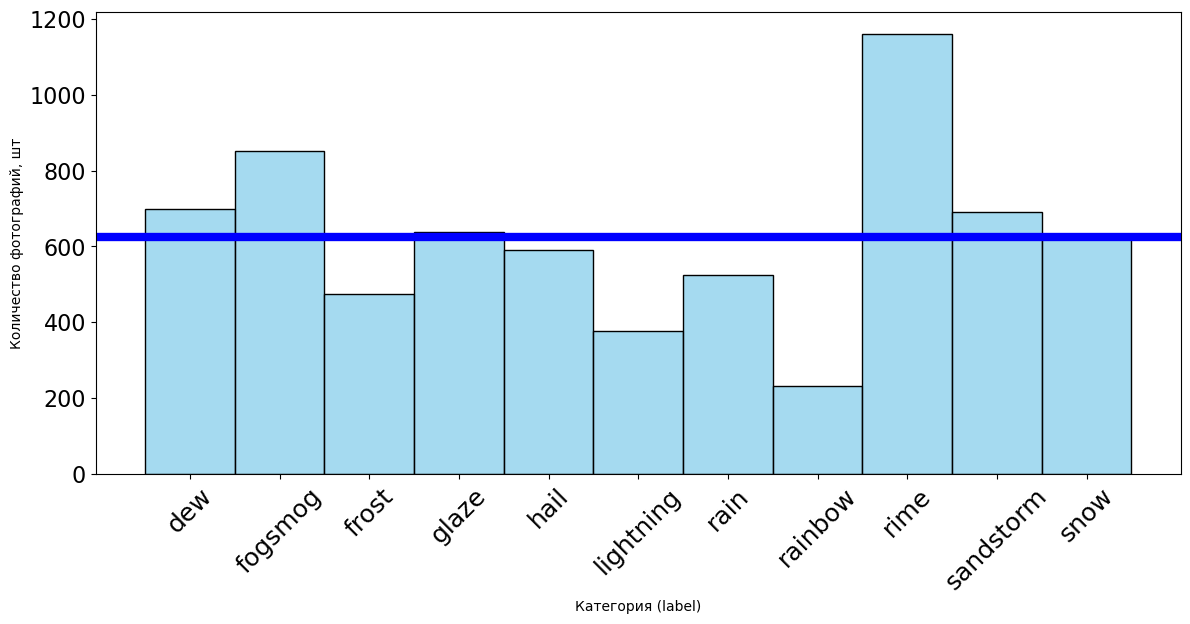

In [ ]:
ax = sns.histplot(data=df, x='label', color='skyblue')
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby('label').count().mean().mean(), lw=6, color='blue')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=16)
ax.set_ylabel('Количество фотографий, шт')
ax.set_xlabel('Категория (label)')

plt.show()

In [ ]:
class_counts = Counter(df['label'])
print('Распределение классов: \n', class_counts)

Распределение классов: 
 Counter({'rime': 1160, 'fogsmog': 851, 'dew': 698, 'sandstorm': 692, 'glaze': 639, 'snow': 621, 'hail': 591, 'rain': 526, 'frost': 475, 'lightning': 377, 'rainbow': 232})


# Вывод примеров фотографий

In [ ]:
examples = pd.DataFrame([])
unique_labels = df['label'].unique()
for label in unique_labels:
    examples = pd.concat([examples, df.query(f"label == '{label}'").sample(1)])

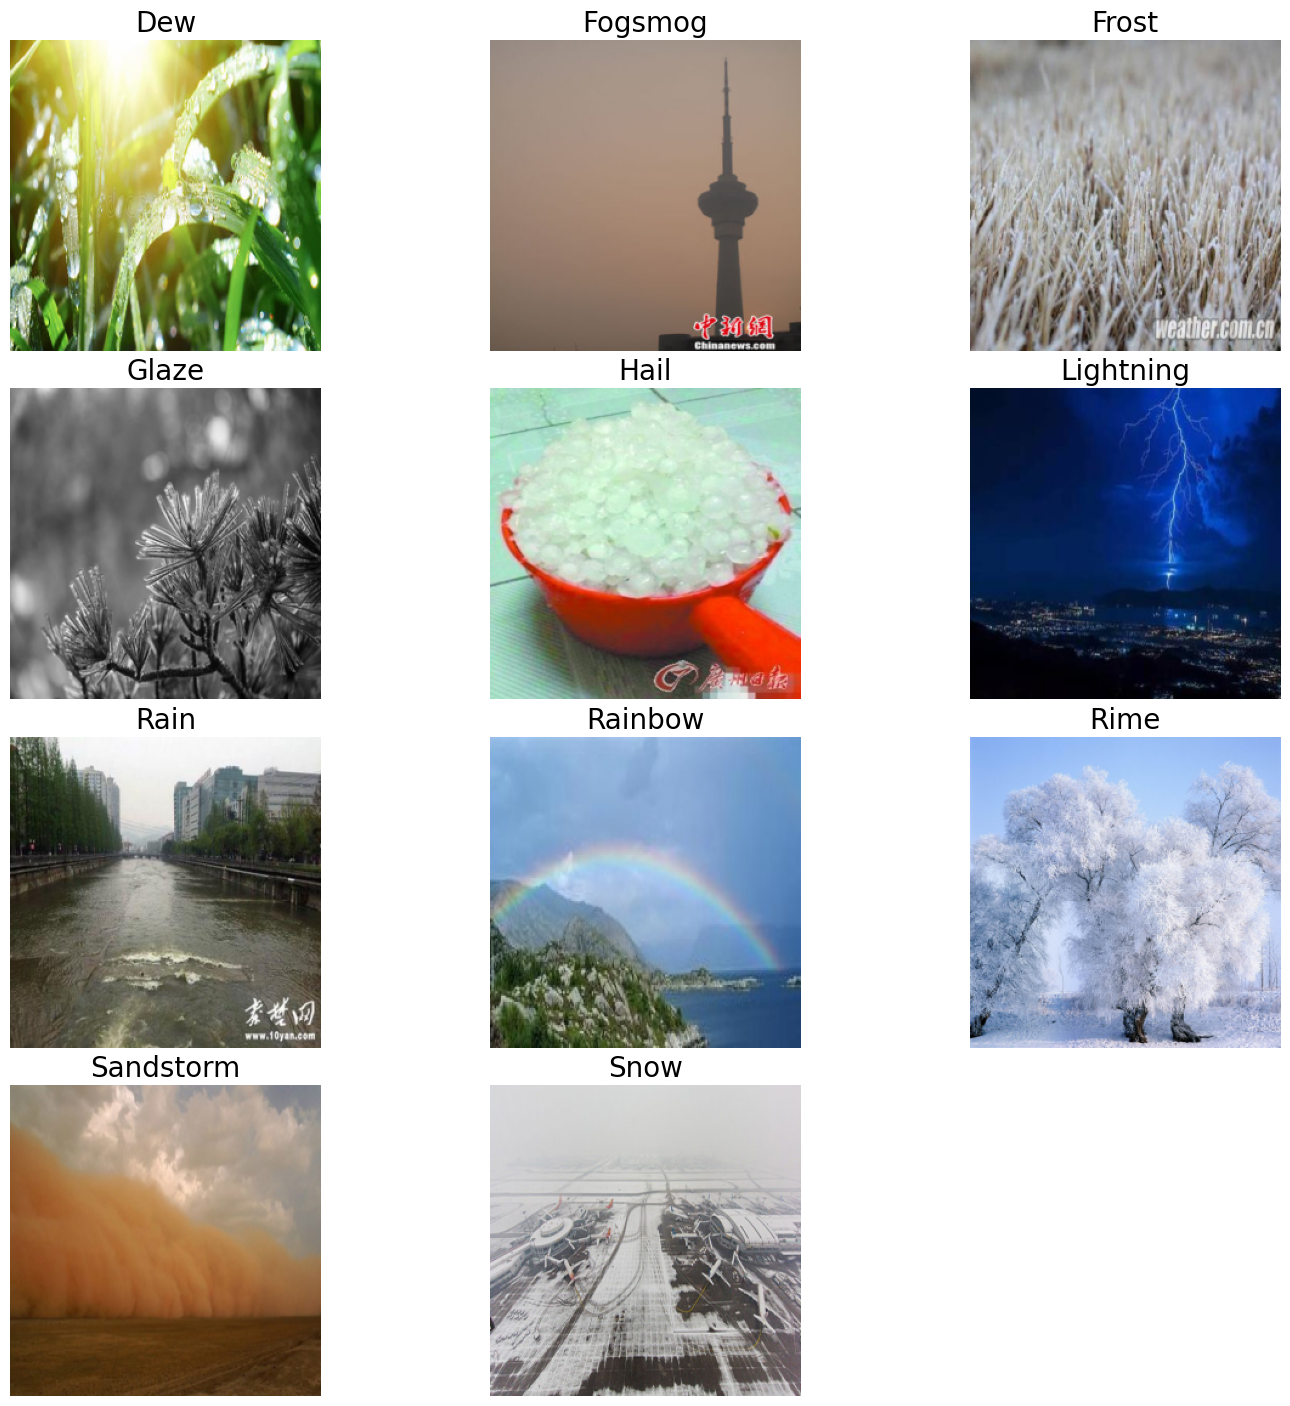

In [ ]:
fig = plt.figure(figsize=(15, 14))
for index, row in examples.reset_index().iterrows():
    ax = plt.subplot(4, 3, index + 1)
    image = cv2.imread(row['image'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    ax.set_title(row['label'].title(), fontsize=20)
    ax.axis('off')

fig.tight_layout(pad=0.5)
plt.show()

# Предобработка данных


### Предобработка фотографий и создание тензоров

In [ ]:
def process_image(img):
    try:
        pic = cv2.imread(img)
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic, (256, 256), interpolation=cv2.INTER_AREA)
        pic = np.array(pic, dtype=np.float32)
        return pic
    except:
        return np.zeros(shape=(256, 256, 3), dtype=np.float32)

In [ ]:
list_of_paths = df['image'].to_numpy()
images = [process_image(path) for path in list_of_paths]
images = np.array(images, dtype=np.float32)
images.shape

(6862, 256, 256, 3)

### Предобработка labels

In [ ]:
def convert_categorical_to_number(label):
    return unique_labels.index(label)

In [ ]:
unique_labels = list(unique_labels)
labels = df['label'].to_numpy()
func = np.vectorize(convert_categorical_to_number)
labels = func(labels)
labels

array([ 0,  0,  0, ..., 10, 10, 10])

### Разделение датасета

In [ ]:
# - 80% для обучения (images_train, labels_train)
# - 10% для валидации (images_val, labels_val)
# - 10% для тестирования (images_test, labels_test)
images_train, images_test_and_val, labels_train, labels_test_and_val = train_test_split(images, labels, test_size=0.2,  random_state=42)
images_val, images_test, labels_val, labels_test = train_test_split(images, labels, test_size=0.5,  random_state=42)

### Перевод в формат для torch

In [ ]:
images_train = torch.from_numpy(images_train).permute(0, 3, 1, 2)
images_val = torch.from_numpy(images_val).permute(0, 3, 1, 2)
images_test = torch.from_numpy(images_test).permute(0, 3, 1, 2)
labels_train = torch.from_numpy(labels_train)
labels_val = torch.from_numpy(labels_val)
labels_test = torch.from_numpy(labels_test)

print("Right sizes for torch:\n")
print("Train", images_train.shape, sep="\n")
print(labels_train.shape)
print("Validation", images_val.shape, sep="\n")
print(labels_val.shape)
print("Test", images_test.shape, sep="\n")
print(labels_test.shape)

Right sizes for torch:

Train
torch.Size([5489, 3, 256, 256])
torch.Size([5489])
Validation
torch.Size([3431, 3, 256, 256])
torch.Size([3431])
Test
torch.Size([3431, 3, 256, 256])
torch.Size([3431])


In [ ]:
# удаляем ненужное
del images
gc.collect()

119

# Загрузка в torch

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [ ]:
class ImagesLabelsDataset(Dataset):
    def __init__(self, images_array, labels_array, scaler_feat=None, scaler_label=None, transform=None):

        self.labels = labels_array
        self.images = images_array
        self.transform = transform

    def __getitem__(self, idx):

        sample = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

    def __len__(self):
        return len(self.labels)

In [ ]:
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4),
        transforms.RandomGrayscale(p=0.1),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


val_transforms = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
batch_size = 32

train_set = ImagesLabelsDataset(images_train, labels_train, train_transforms)
val_set = ImagesLabelsDataset(images_val, labels_val, val_transforms)
test_set = ImagesLabelsDataset(images_test, labels_test, test_transforms)

train_loader = DataLoader(train_set,
                          batch_size,
                          shuffle=True)
val_loader = DataLoader(val_set,
                        batch_size,
                        shuffle=False)
test_loader = DataLoader(test_set,
                         batch_size,
                         shuffle=False)

In [ ]:
# Проверка
for batch in train_loader:
    img, lbl = batch
    print('Batch shape')
    print(img.size(), lbl.size())
    break

Batch shape
torch.Size([32, 3, 256, 256]) torch.Size([32])


# Загрузка модели

In [ ]:
model = create_model('vgg16', pretrained=True, num_classes=11)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Обучение модели

In [ ]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
def validate(model, testloader, criterion):
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            labels = labels.long()
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
lr = 1e-4
weight_decay = 1e-6
n_epochs = 13

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.01, factor=0.31, patience=3)

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(n_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {n_epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    scheduler.step(valid_epoch_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:17<00:00,  6.09it/s]


Training loss: 1.023, training acc: 67.717
Validation loss: 0.598, validation acc: 80.793
--------------------------------------------------
[INFO]: Epoch 2 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:17<00:00,  6.03it/s]


Training loss: 0.498, training acc: 84.132
Validation loss: 0.305, validation acc: 90.382
--------------------------------------------------
[INFO]: Epoch 3 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.77it/s]


Training loss: 0.321, training acc: 89.306
Validation loss: 0.280, validation acc: 91.693
--------------------------------------------------
[INFO]: Epoch 4 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.97it/s]


Training loss: 0.288, training acc: 90.818
Validation loss: 0.241, validation acc: 93.413
--------------------------------------------------
[INFO]: Epoch 5 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.82it/s]


Training loss: 0.234, training acc: 92.367
Validation loss: 0.106, validation acc: 96.794
--------------------------------------------------
[INFO]: Epoch 6 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.72it/s]


Training loss: 0.200, training acc: 93.496
Validation loss: 0.056, validation acc: 98.543
--------------------------------------------------
[INFO]: Epoch 7 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.89it/s]


Training loss: 0.102, training acc: 96.666
Validation loss: 0.096, validation acc: 96.561
--------------------------------------------------
[INFO]: Epoch 8 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.87it/s]


Training loss: 0.055, training acc: 98.160
Validation loss: 0.015, validation acc: 99.534
--------------------------------------------------
[INFO]: Epoch 9 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.78it/s]


Training loss: 0.069, training acc: 98.051
Validation loss: 0.076, validation acc: 98.076
--------------------------------------------------
[INFO]: Epoch 10 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.74it/s]


Training loss: 0.154, training acc: 95.810
Validation loss: 0.082, validation acc: 97.668
--------------------------------------------------
[INFO]: Epoch 11 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:18<00:00,  5.79it/s]


Training loss: 0.253, training acc: 92.476
Validation loss: 0.146, validation acc: 95.541
--------------------------------------------------
[INFO]: Epoch 12 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:19<00:00,  5.68it/s]


Training loss: 0.097, training acc: 97.049
Validation loss: 0.034, validation acc: 99.096
--------------------------------------------------
[INFO]: Epoch 13 of 13


100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:19<00:00,  5.56it/s]

Training loss: 0.017, training acc: 99.344
Validation loss: 0.002, validation acc: 99.913
--------------------------------------------------
TRAINING COMPLETE


# Результаты обучения

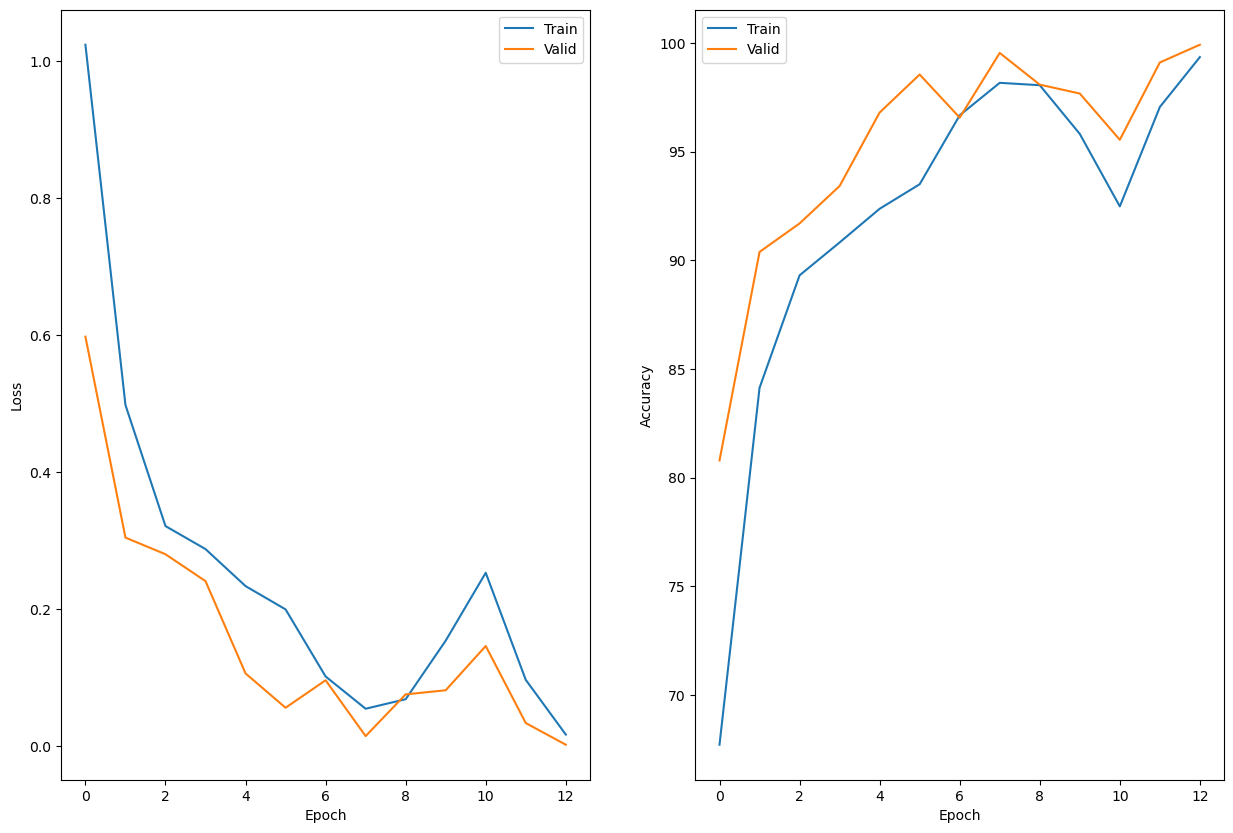

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train')
plt.plot(valid_acc, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = validate(model, test_loader, criterion)

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:19<00:00,  5.68it/s]


In [ ]:
# loss и accuracy на тестовой выборке
test_loss, test_acc

(0.23305855904453032, 95.39492859224717)

In [ ]:
# Сохранение весов модели
torch.save(model.state_dict(), 'vgg16_weather_classifier.pth')